In [1]:
# Import necessary modules
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyspark.sql.functions as F
import seaborn as sns
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.functions import (
    col,
    count,
    from_unixtime,
    isnan,
    regexp_extract,
    split,
)
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.functions import to_timestamp, udf, unix_timestamp, when
from pyspark.sql.session import SparkSession
from pyspark.sql.types import StringType, TimestampType
from pyspark.sql.window import Window

# Set up matplotlib to work in Jupyter notebooks
%matplotlib inline

In [2]:
# Create SparkContext, SQLContext, and SparkSession objects

sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/30 20:49:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/Users/aditshrimal/opt/anaconda3/envs/DistributedDataSystems/lib/python3.10/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:

# Print the SparkSession

spark

In [4]:
# rdd = sc.textFile("/Users/aditshrimal/Desktop/MSDS/summer23/assignments/log-analytics/dataset/NASA_access_log_Aug95.gz")
# rdd.take(5)

In [5]:
# Load the data into a DataFrame

df1 = spark.read.text(
    "/Users/aditshrimal/Desktop/MSDS/summer23/assignments/log-analytics/dataset/NASA_access_log_Jul95.gz"
)

df2 = spark.read.text(
    "/Users/aditshrimal/Desktop/MSDS/summer23/assignments/log-analytics/dataset/NASA_access_log_Aug95.gz"
)

df = df1.union(df2)

In [6]:
df.show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                  |
+-----------------------------------------------------------------------------------------------------------------------+
|199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245                                 |
|unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985                      |
|199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085   |
|burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0               |
|199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179|
+-----------------------

The logs are an ASCII file with one line per request, with the following columns:
1. host making the request. A hostname when possible, otherwise the Internet address if the name could not be looked up.
2. timestamp in the format "DAY MON DD HH:MM:SS YYYY", where DAY is the day of the week, MON is the name of the month, DD is the day of the month, HH:MM:SS is the time of day using a 24-hour clock, and YYYY is the year. The timezone is -0400.
3. request given in quotes.
4. HTTP reply code.
5. bytes in the reply.

In [7]:
# Parse the log data into separate columns

df_parsed = df.select(
    regexp_extract("value", r"^([^\s]+\s)", 1).alias("host"),
    regexp_extract(
        "value", r"^.*\[(\d\d/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]", 1
    ).alias("timestamp"),
    regexp_extract("value", r'^.*"\s*(\w+)\s+([^\s]+)\s+([^\s]+)"', 1).alias("method"),
    regexp_extract("value", r'^.*"\s*(\w+)\s+([^\s]+)\s+([^\s]+)"', 2).alias(
        "endpoint"
    ),
    regexp_extract("value", r'^.*"\s*(\w+)\s+([^\s]+)\s+([^\s]+)"', 3).alias(
        "protocol"
    ),
    regexp_extract("value", r'^.*"\s+([^\s]+)', 1).cast("integer").alias("status"),
    regexp_extract("value", r"^.*\s+(\d+)$", 1).cast("integer").alias("content_size"),
)

In [8]:
df_parsed.show(5, truncate=False)

+---------------------+--------------------------+------+-----------------------------------------------+--------+------+------------+
|host                 |timestamp                 |method|endpoint                                       |protocol|status|content_size|
+---------------------+--------------------------+------+-----------------------------------------------+--------+------+------------+
|199.72.81.55         |01/Jul/1995:00:00:01 -0400|GET   |/history/apollo/                               |HTTP/1.0|200   |6245        |
|unicomp6.unicomp.net |01/Jul/1995:00:00:06 -0400|GET   |/shuttle/countdown/                            |HTTP/1.0|200   |3985        |
|199.120.110.21       |01/Jul/1995:00:00:09 -0400|GET   |/shuttle/missions/sts-73/mission-sts-73.html   |HTTP/1.0|200   |4085        |
|burger.letters.com   |01/Jul/1995:00:00:11 -0400|GET   |/shuttle/countdown/liftoff.html                |HTTP/1.0|304   |0           |
|199.120.110.21       |01/Jul/1995:00:00:11 -0400|GET  

In [9]:
# Define a function to count the number of null values in a column

def count_null(col_name):
    return df_parsed.filter(col(col_name).isNull()).count()

# Count the number of null values in each column
exprs = {col_name: count_null(col_name) for col_name in df_parsed.columns}

exprs

{'host': 0,
 'timestamp': 0,
 'method': 0,
 'endpoint': 0,
 'protocol': 0,
 'status': 1,
 'content_size': 33905}

In [10]:
# Identify the rows where the content_size is null

null_content_size_df = df.filter(~df["value"].rlike(r"\s\d+$"))
null_content_size_df.count()

33905

In [11]:
null_content_size_df.take(10)

[Row(value='dd15-062.compuserve.com - - [01/Jul/1995:00:01:12 -0400] "GET /news/sci.space.shuttle/archive/sci-space-shuttle-22-apr-1995-40.txt HTTP/1.0" 404 -'),
 Row(value='dynip42.efn.org - - [01/Jul/1995:00:02:14 -0400] "GET /software HTTP/1.0" 302 -'),
 Row(value='ix-or10-06.ix.netcom.com - - [01/Jul/1995:00:02:40 -0400] "GET /software/winvn HTTP/1.0" 302 -'),
 Row(value='ix-or10-06.ix.netcom.com - - [01/Jul/1995:00:03:24 -0400] "GET /software HTTP/1.0" 302 -'),
 Row(value='link097.txdirect.net - - [01/Jul/1995:00:05:06 -0400] "GET /shuttle HTTP/1.0" 302 -'),
 Row(value='ix-war-mi1-20.ix.netcom.com - - [01/Jul/1995:00:05:13 -0400] "GET /shuttle/missions/sts-78/news HTTP/1.0" 302 -'),
 Row(value='ix-war-mi1-20.ix.netcom.com - - [01/Jul/1995:00:05:58 -0400] "GET /shuttle/missions/sts-72/news HTTP/1.0" 302 -'),
 Row(value='netport-27.iu.net - - [01/Jul/1995:00:10:19 -0400] "GET /pub/winvn/readme.txt HTTP/1.0" 404 -'),
 Row(value='netport-27.iu.net - - [01/Jul/1995:00:10:28 -0400] "GET

### Fixing the rows with null content_size

In [12]:
# Replace the null values in the content_size column with 0

df_parsed = df_parsed.na.fill({"content_size": 0})

In [13]:
# Count the number of null values in each column after the replacement

exprs = {col_name: count_null(col_name) for col_name in df_parsed.columns}
exprs

{'host': 0,
 'timestamp': 0,
 'method': 0,
 'endpoint': 0,
 'protocol': 0,
 'status': 1,
 'content_size': 0}

### Handling Temporal Fields (Timestamp)

In [14]:
# Define a function to convert the string to timestamp
def parse_date(df, column, pattern):
    return df.withColumn(column, from_unixtime(unix_timestamp(df[column], pattern)).cast(TimestampType()))

In [15]:
df_parsed.show(5, truncate=False)

+---------------------+--------------------------+------+-----------------------------------------------+--------+------+------------+
|host                 |timestamp                 |method|endpoint                                       |protocol|status|content_size|
+---------------------+--------------------------+------+-----------------------------------------------+--------+------+------------+
|199.72.81.55         |01/Jul/1995:00:00:01 -0400|GET   |/history/apollo/                               |HTTP/1.0|200   |6245        |
|unicomp6.unicomp.net |01/Jul/1995:00:00:06 -0400|GET   |/shuttle/countdown/                            |HTTP/1.0|200   |3985        |
|199.120.110.21       |01/Jul/1995:00:00:09 -0400|GET   |/shuttle/missions/sts-73/mission-sts-73.html   |HTTP/1.0|200   |4085        |
|burger.letters.com   |01/Jul/1995:00:00:11 -0400|GET   |/shuttle/countdown/liftoff.html                |HTTP/1.0|304   |0           |
|199.120.110.21       |01/Jul/1995:00:00:11 -0400|GET  

In [16]:
# Specify the date pattern

date_pattern = "dd/MMM/yyyy:HH:mm:ss -SSSS"
df_parsed = parse_date(df_parsed, "timestamp", date_pattern)

In [17]:
df_parsed = df_parsed.withColumn("timestamp", to_timestamp(df_parsed["timestamp"]))
df_parsed.show(5, truncate=False)

+---------------------+-------------------+------+-----------------------------------------------+--------+------+------------+
|host                 |timestamp          |method|endpoint                                       |protocol|status|content_size|
+---------------------+-------------------+------+-----------------------------------------------+--------+------+------------+
|199.72.81.55         |1995-07-01 00:00:01|GET   |/history/apollo/                               |HTTP/1.0|200   |6245        |
|unicomp6.unicomp.net |1995-07-01 00:00:06|GET   |/shuttle/countdown/                            |HTTP/1.0|200   |3985        |
|199.120.110.21       |1995-07-01 00:00:09|GET   |/shuttle/missions/sts-73/mission-sts-73.html   |HTTP/1.0|200   |4085        |
|burger.letters.com   |1995-07-01 00:00:11|GET   |/shuttle/countdown/liftoff.html                |HTTP/1.0|304   |0           |
|199.120.110.21       |1995-07-01 00:00:11|GET   |/shuttle/missions/sts-73/sts-73-patch-small.gif|HTTP/1

In [18]:
df_parsed.printSchema()

root
 |-- host: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = false)



In [19]:
# Cache the DataFrame to speed up subsequent operations
df_parsed.cache()

DataFrame[host: string, timestamp: timestamp, method: string, endpoint: string, protocol: string, status: int, content_size: int]

## Exploratory Data Analysis

### Content Size Analysis

In [20]:
df_parsed.filter(df_parsed['content_size']=='').show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
+----+---------+------+--------+--------+------+------------+



In [21]:
# Analyzing the 'content_size' field
content_size_summary_df = df_parsed.describe(["content_size"])
content_size_summary_df.toPandas()

,summary,content_size
0,count,3461613
1,mean,18928.838930001708
2,stddev,73031.46276937172
3,min,0
4,max,6823936


### HTTP Status Analysis

In [22]:
# Analyzing the HTTP Status Codes. We group by status and count
status_freq_df = df_parsed.groupBy("status").count().sort("status").cache()
print("Total distinct HTTP Status Codes:", status_freq_df.count())

Total distinct HTTP Status Codes: 9


In [23]:
# Convert status_freq_df to a pandas DataFrame and sort it by the count column
status_freq_pd_df = status_freq_df.toPandas().sort_values(by=["count"], ascending=False)
status_freq_pd_df

,status,count
1,200.0,3100522
3,304.0,266773
2,302.0,73070
6,404.0,20901
5,403.0,225
7,500.0,65
8,501.0,41
4,400.0,15
0,NaN,1


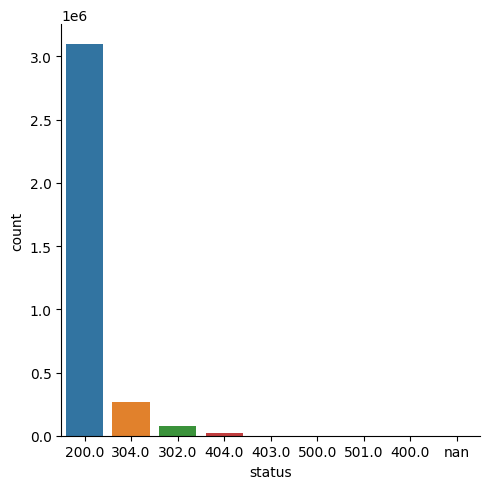

In [24]:
# Visualize the HTTP Status Codes
sns.catplot(
    x="status",
    y="count",
    data=status_freq_pd_df,
    kind="bar",
    order=status_freq_pd_df["status"],
)

#### Log transformation

In [25]:
# Applying a log transformation to visualize the data better
log_freq_df = status_freq_df.withColumn("log(count)", F.log(status_freq_df["count"]))
log_freq_df.show()

+------+-------+------------------+
|status|  count|        log(count)|
+------+-------+------------------+
|  null|      1|               0.0|
|   200|3100522|14.947081042376633|
|   302|  73070|11.199173164785263|
|   304| 266773|12.494153388502301|
|   400|     15|  2.70805020110221|
|   403|    225|  5.41610040220442|
|   404|  20901|  9.94755228369823|
|   500|     65| 4.174387269895637|
|   501|     41| 3.713572066704308|
+------+-------+------------------+



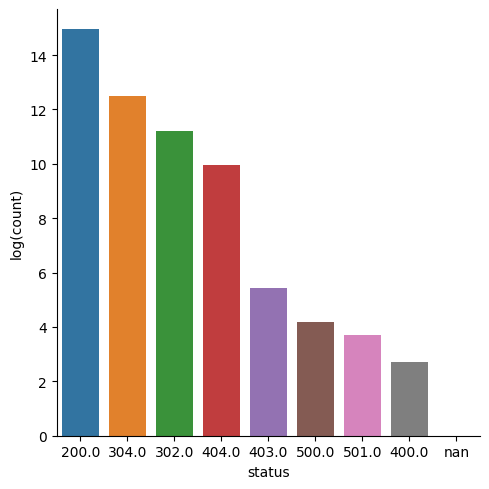

In [26]:
# Visualize the HTTP Status Codes after log transformation
log_freq_pd_df = log_freq_df.toPandas().sort_values(by=["log(count)"], ascending=False)
sns.catplot(
    x="status",
    y="log(count)",
    data=log_freq_pd_df,
    kind="bar",
    order=status_freq_pd_df["status"],
)

### Analyzing Frequent Hosts

In [27]:
# Analyze the top 10 hosts who accessed the web server the most
host_sum_df = df_parsed.groupBy("host").count().sort("count", ascending=False).limit(10)

host_sum_df.show(truncate=False)

+---------------------+-----+
|host                 |count|
+---------------------+-----+
|piweba3y.prodigy.com |21988|
|piweba4y.prodigy.com |16437|
|piweba1y.prodigy.com |12825|
|edams.ksc.nasa.gov   |11964|
|163.206.89.4         |9697 |
|news.ti.com          |8161 |
|www-d1.proxy.aol.com |8047 |
|alyssa.prodigy.com   |8037 |
|siltb10.orl.mmc.com  |7573 |
|www-a2.proxy.aol.com |7516 |
+---------------------+-----+



### Top 20 Frequent EndPoints

In [28]:
# Analyze the top 20 endpoints requested by the users
paths_df = (
    df_parsed.groupBy("endpoint").count().sort("count", ascending=False).limit(20)
)

paths_pd_df = paths_df.toPandas()
paths_pd_df

,endpoint,count
0,/images/NASA-logosmall.gif,208353
1,/images/KSC-logosmall.gif,164807
2,/images/MOSAIC-logosmall.gif,127648
3,/images/USA-logosmall.gif,126812
4,/images/WORLD-logosmall.gif,125668
5,/images/ksclogo-medium.gif,121278
6,/ksc.html,83682
7,/images/launch-logo.gif,75957
8,/history/apollo/images/apollo-logo1.gif,68856
9,/shuttle/countdown/,64692


### Top 10 Error Endpoints

In [29]:
# Identify the top 10 endpoints which resulted in an HTTP response other than 200
not200_df = df_parsed.filter(df_parsed["status"] != 200)

error_endpoints_freq_df = (
    not200_df.groupBy("endpoint").count().sort("count", ascending=False).limit(10)
)

error_endpoints_freq_df.show(truncate=False)

+---------------------------------------+-----+
|endpoint                               |count|
+---------------------------------------+-----+
|/images/NASA-logosmall.gif             |40082|
|/images/KSC-logosmall.gif              |23763|
|/images/MOSAIC-logosmall.gif           |15245|
|/images/USA-logosmall.gif              |15142|
|/images/WORLD-logosmall.gif            |14773|
|/images/ksclogo-medium.gif             |13559|
|/images/launch-logo.gif                |8806 |
|/history/apollo/images/apollo-logo1.gif|7489 |
|/                                      |6296 |
|/images/ksclogosmall.gif               |5669 |
+---------------------------------------+-----+



### Total number of Unique Hosts

In [30]:
# Count the total number of unique hosts
unique_host_count = df_parsed.select("host").distinct().count()
unique_host_count

137979

### Number of Unique Daily Hosts

In [31]:
# Find the number of unique hosts in the entire log on a day-by-day basis
host_day_df = df_parsed.select(df_parsed.host, F.dayofmonth("timestamp").alias("day"))
host_day_df.show(5, truncate=False)

+---------------------+---+
|host                 |day|
+---------------------+---+
|199.72.81.55         |1  |
|unicomp6.unicomp.net |1  |
|199.120.110.21       |1  |
|burger.letters.com   |1  |
|199.120.110.21       |1  |
+---------------------+---+
only showing top 5 rows



In [32]:
# Visualize the daily_hosts_df DataFrame
host_day_distinct_df = host_day_df.dropDuplicates()
host_day_distinct_df.show(5, truncate=False)

+----------------------------+---+
|host                        |day|
+----------------------------+---+
|x164glen.glen-net.ca        |1  |
|maria-5e.aip.realtime.net   |1  |
|ix-ham-oh1-19.ix.netcom.com |1  |
|dd12-021.compuserve.com     |1  |
|ip16-019.phx.primenet.com   |1  |
+----------------------------+---+
only showing top 5 rows



In [33]:
daily_hosts_df = host_day_distinct_df.groupBy("day").count().sort("day")

daily_hosts_df = daily_hosts_df.toPandas()
daily_hosts_df

,day,count
0,NaN,1
1,1.0,7615
2,2.0,4859
3,3.0,10244
4,4.0,9415
5,5.0,9644
6,6.0,10140
7,7.0,10054
8,8.0,7117
9,9.0,6703


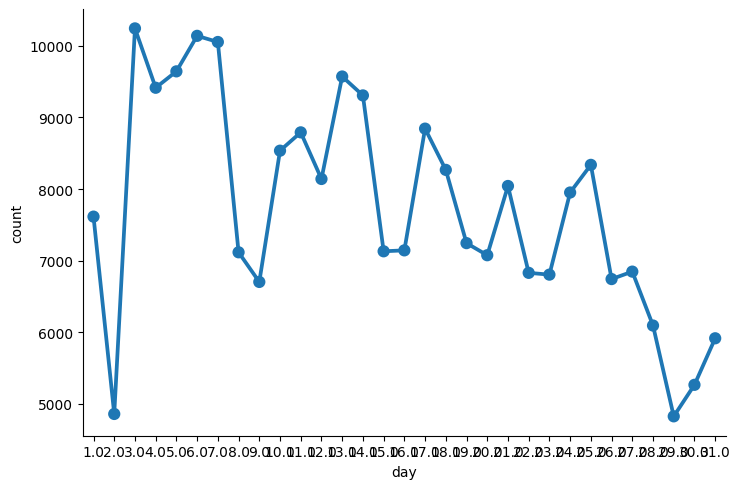

In [34]:
# Visualize the daily_hosts_df DataFrame
c = sns.catplot(
    x="day", y="count", data=daily_hosts_df, kind="point", height=5, aspect=1.5
)

### Average Number of Daily Requests per Host

In [35]:
# Calculate the average number of requests daily per Host
daily_hosts_df = (
    host_day_distinct_df.groupBy("day")
    .count()
    .select(col("day"), col("count").alias("total_hosts"))
)

In [36]:
total_daily_reqests_df = (
    df_parsed.select(F.dayofmonth("timestamp").alias("day"))
    .groupBy("day")
    .count()
    .select(col("day"), col("count").alias("total_reqs"))
)

In [37]:
avg_daily_reqests_per_host_df = total_daily_reqests_df.join(daily_hosts_df, "day")
avg_daily_reqests_per_host_df = avg_daily_reqests_per_host_df.withColumn(
    "avg_reqs", col("total_reqs") / col("total_hosts")
).sort("day")

In [38]:
# Visualize the average daily requests per host
avg_daily_reqests_per_host_df = avg_daily_reqests_per_host_df.toPandas()
avg_daily_reqests_per_host_df

,day,total_reqs,total_hosts,avg_reqs
0,1,98710,7615,12.962574
1,2,60265,4859,12.402758
2,3,130972,10244,12.785240
3,4,130009,9415,13.808710
4,5,126468,9644,13.113646
5,6,133380,10140,13.153846
6,7,144595,10054,14.381838
7,8,99024,7117,13.913728
8,9,95730,6703,14.281665
9,10,134108,8536,15.710872


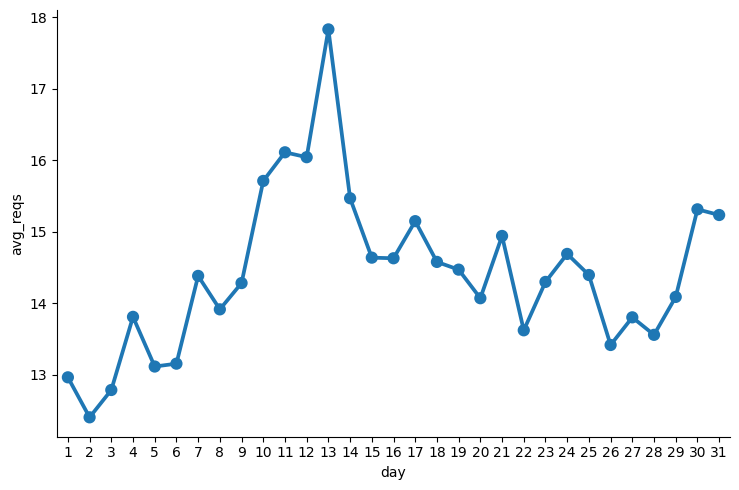

In [39]:
c = sns.catplot(
    x="day",
    y="avg_reqs",
    data=avg_daily_reqests_per_host_df,
    kind="point",
    height=5,
    aspect=1.5,
)

### Counting 404 Response Codes

In [40]:
# Analyze 404 response codes
not_found_df = df_parsed.filter(df_parsed["status"] == 404).cache()
print(("Total 404 responses: {}").format(not_found_df.count()))

Total 404 responses: 20901


### Top Twenty 404 Response Code Endpoints

In [41]:
# Analyze top 20 endpoints causing 404 errors
endpoints_404_count_df = (
    not_found_df.groupBy("endpoint").count().sort("count", ascending=False).limit(20)
)

endpoints_404_count_df.show(truncate=False)

+-----------------------------------------------------------------+-----+
|endpoint                                                         |count|
+-----------------------------------------------------------------+-----+
|/pub/winvn/readme.txt                                            |2004 |
|/pub/winvn/release.txt                                           |1732 |
|/shuttle/missions/STS-69/mission-STS-69.html                     |682  |
|/shuttle/missions/sts-68/ksc-upclose.gif                         |426  |
|/history/apollo/a-001/a-001-patch-small.gif                      |384  |
|/history/apollo/sa-1/sa-1-patch-small.gif                        |383  |
|/://spacelink.msfc.nasa.gov                                      |381  |
|/images/crawlerway-logo.gif                                      |374  |
|/elv/DELTA/uncons.htm                                            |372  |
|/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif|359  |
|/images/nasa-logo.gif                

### Top Twenty 404 Response Code Hosts

In [42]:
# Analyze top 20 hosts causing 404 errors
hosts_404_count_df = (
    not_found_df.groupBy("host").count().sort("count", ascending=False).limit(20)
)

hosts_404_count_df.show(truncate=False)

+----------------------------+-----+
|host                        |count|
+----------------------------+-----+
|hoohoo.ncsa.uiuc.edu        |251  |
|piweba3y.prodigy.com        |157  |
|jbiagioni.npt.nuwc.navy.mil |132  |
|piweba1y.prodigy.com        |114  |
|www-d4.proxy.aol.com        |91   |
|piweba4y.prodigy.com        |86   |
|scooter.pa-x.dec.com        |69   |
|www-d1.proxy.aol.com        |64   |
|phaelon.ksc.nasa.gov        |64   |
|www-b4.proxy.aol.com        |62   |
|dialip-217.den.mmc.com      |62   |
|www-b3.proxy.aol.com        |61   |
|www-a2.proxy.aol.com        |60   |
|titan02f                    |59   |
|www-d2.proxy.aol.com        |59   |
|piweba2y.prodigy.com        |59   |
|alyssa.prodigy.com          |56   |
|monarch.eng.buffalo.edu     |56   |
|www-c4.proxy.aol.com        |53   |
|www-b2.proxy.aol.com        |53   |
+----------------------------+-----+



### Visualizing 404 Errors per Day

In [43]:
# Visualize 404 errors by day
errors_by_date_sorted_df = (
    not_found_df.groupBy(F.dayofmonth("timestamp").alias("day")).count().sort("day")
)

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_pd_df

,day,count
0,1,559
1,2,291
2,3,778
3,4,705
4,5,733
5,6,1013
6,7,1107
7,8,693
8,9,627
9,10,713


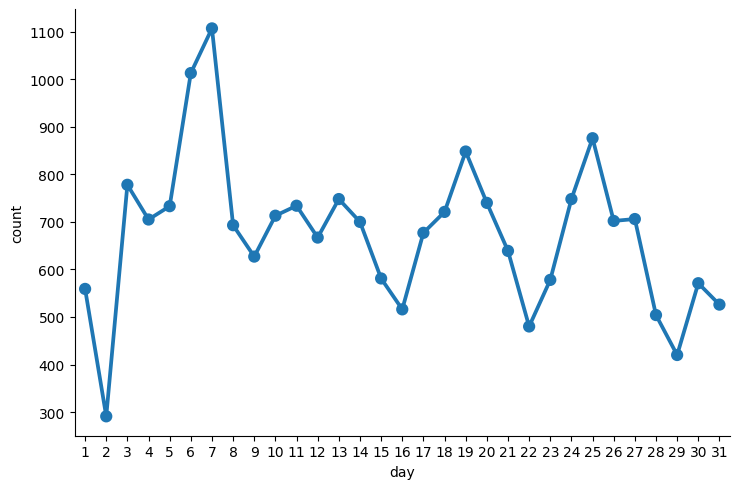

In [44]:
c = sns.catplot(
    x="day",
    y="count",
    data=errors_by_date_sorted_pd_df,
    kind="point",
    height=5,
    aspect=1.5,
)

### Top Three Days for 404 Errors

In [45]:
# Identify the three days with the most 404 errors
(errors_by_date_sorted_df.sort("count", ascending=False).show(3))

+---+-----+
|day|count|
+---+-----+
|  7| 1107|
|  6| 1013|
| 25|  876|
+---+-----+
only showing top 3 rows



### Visualizing Hourly 404 Errors

In [46]:
# Visualize 404 errors by hour
hourly_avg_errors_sorted_df = (
    not_found_df.groupBy(F.hour("timestamp").alias("hour")).count().sort("hour")
)
hourly_avg_errors_sorted_pd_df = hourly_avg_errors_sorted_df.toPandas()

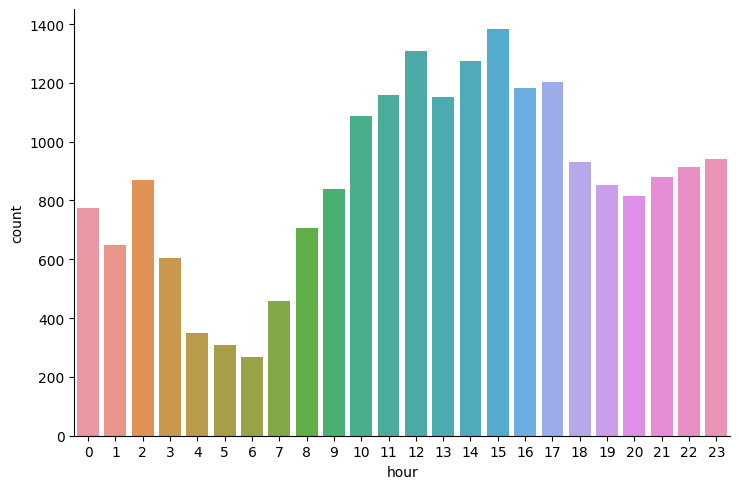

In [47]:
c = sns.catplot(
    x="hour",
    y="count",
    data=hourly_avg_errors_sorted_pd_df,
    kind="bar",
    height=5,
    aspect=1.5,
)

### 3.1 Generate the output presenting the endpoint that received the highest number of invocations on a specific day of the week, along with the corresponding count of invocations. (Summarize this for the entire dataset)
#### 3.1.1 Output:
#### Day in a week: Day in a week
#### Endpoint: endpoint which was invoked the most.
#### Count: Number of times it's been invoked
#### 3.1.2 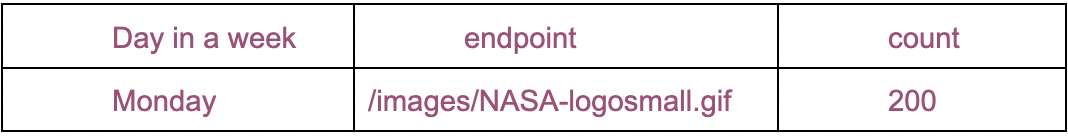

In [48]:
# Find the most frequently accessed endpoint for each day of the week
df_parsed = df_parsed.withColumn("day_of_week", F.date_format("timestamp", "EEEE")) \
    .withColumn("day_of_week_num", F.dayofweek("timestamp"))

In [56]:
df_parsed = df_parsed.filter(df_parsed.day_of_week.isNotNull())

In [57]:
df_grouped = df_parsed.groupBy("day_of_week_num","day_of_week", "endpoint").count()

In [58]:
window = Window.partitionBy("day_of_week").orderBy(F.desc("count"))
df_result = df_grouped.withColumn("rn", F.row_number().over(window)).filter(
    F.col("rn") == 1
)

In [59]:
df_result.sort("day_of_week_num").select("day_of_week", "endpoint", "count").show()

+-----------+--------------------+-----+
|day_of_week|            endpoint|count|
+-----------+--------------------+-----+
|     Sunday|/images/KSC-logos...|15202|
|     Monday|/images/NASA-logo...|30330|
|    Tuesday|/images/NASA-logo...|33614|
|  Wednesday|/images/NASA-logo...|37531|
|   Thursday|/images/NASA-logo...|46871|
|     Friday|/images/NASA-logo...|29095|
|   Saturday|/images/KSC-logos...|16138|
+-----------+--------------------+-----+



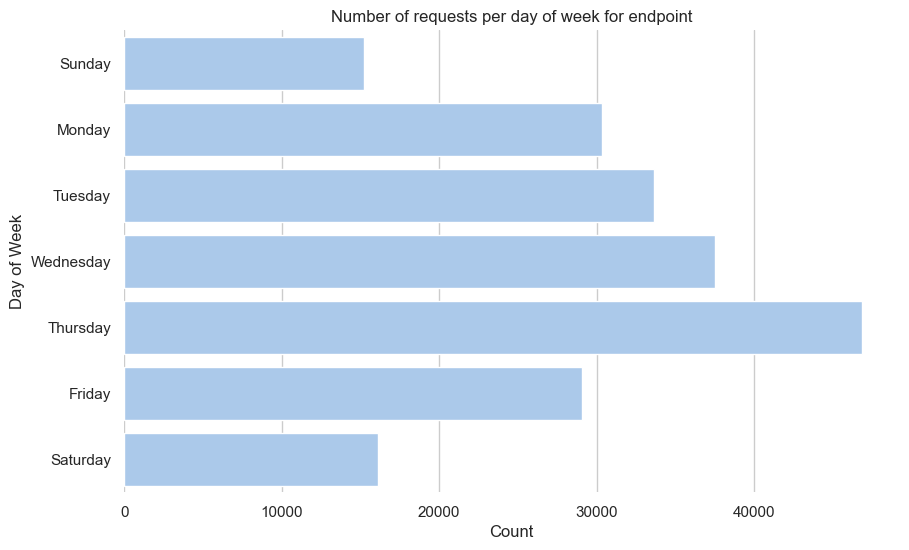

In [61]:
pandas_df = df_result.sort("day_of_week_num").select("day_of_week", "endpoint", "count").toPandas()

# Set the style of seaborn
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="count", y="day_of_week", data=pandas_df,
            label="Total", color="b")

# Add a legend and informative axis label
plt.xlabel('Count')
plt.ylabel('Day of Week')
plt.title('Number of requests per day of week for endpoint')
sns.despine(left=True, bottom=True)

plt.show()

### 3.2 Total number of 404 status codes generated in each day of a week(For Monday, Tuesday,..… Sunday) for the entire dataset.

In [60]:
# Filter for the rows with status code 404
df = df_parsed.filter(F.col("status") == 404)

# Group by the day of the week and count the number of rows
df_grouped = df.groupBy("day_of_week_num","day_of_week").count()

# Display the result
df_grouped.sort("day_of_week_num").select("day_of_week","count").show()

+-----------+-----+
|day_of_week|count|
+-----------+-----+
|     Sunday| 2400|
|     Monday| 3145|
|    Tuesday| 3425|
|  Wednesday| 3397|
|   Thursday| 3772|
|     Friday| 2691|
|   Saturday| 2071|
+-----------+-----+



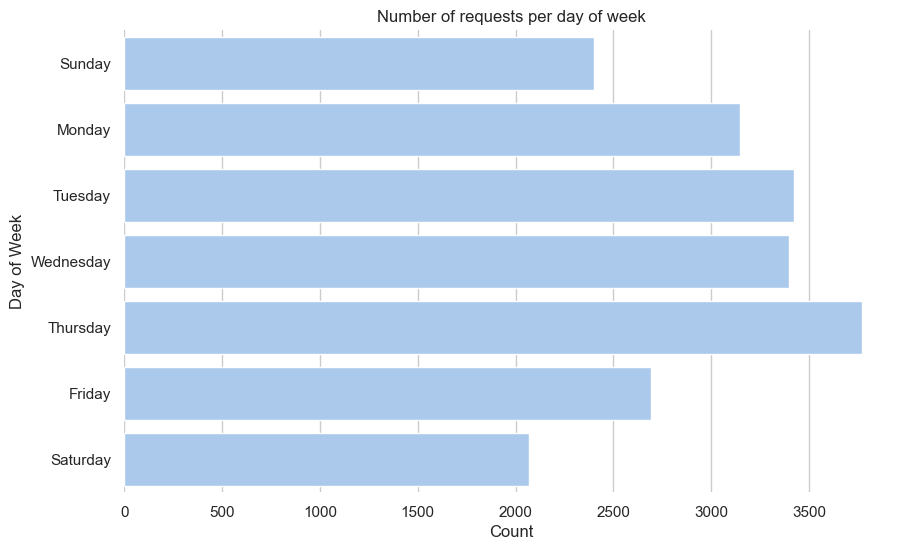

In [62]:
pandas_df = df_grouped.sort("day_of_week_num").select("day_of_week","count").toPandas()

# Set the style of seaborn
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="count", y="day_of_week", data=pandas_df,
            label="Total", color="b")

# Add a legend and informative axis label
plt.xlabel('Count')
plt.ylabel('Day of Week')
plt.title('Number of requests per day of week')
sns.despine(left=True, bottom=True)

plt.show()